# Bank Marketing — EDA & Modeling

## Установка зависимостей (при необходимости)

In [28]:
# !pip install -U pandas numpy scikit-learn matplotlib catboost joblib pyyaml

## 0. Импорт и базовые настройки

In [ ]:
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
SEED = 42
np.random.seed(SEED)
print('Готово к работе.')

Готово к работе.


## 1. Загрузка данных
Ожидаются файлы:
```
data/raw/train.csv
data/raw/test.csv   # опционально
```
Если теста нет — инференс будет пропущен.

In [30]:
RAW_DIR = Path('data/raw')
train_path = RAW_DIR / 'train.csv'
test_path = RAW_DIR / 'test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path) if test_path.exists() else None
print('train shape:', train.shape)
print('test shape :', None if test is None else test.shape)
train.head()

train shape: (750000, 18)
test shape : (250000, 17)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


## 2. EDA — краткий обзор

In [31]:
info_df = pd.DataFrame({
    'column': train.columns,
    'dtype': train.dtypes.astype(str).values,
    'n_unique': [train[c].nunique() for c in train.columns],
    'missing': train.isna().sum().values,
})
info_df.head(20)

,column,dtype,n_unique,missing
0,id,int64,750000,0
1,age,int64,78,0
2,job,object,12,0
3,marital,object,3,0
4,education,object,4,0
5,default,object,2,0
6,balance,int64,8217,0
7,housing,object,2,0
8,loan,object,2,0
9,contact,object,3,0


   y   count     ratio
0  0  659512  0.879349
1  1   90488  0.120651


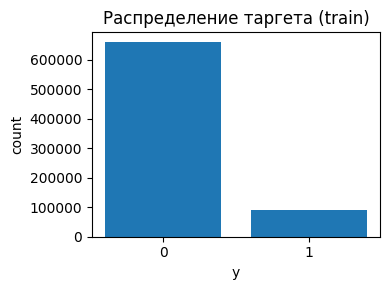

In [ ]:
vc = train['y'].value_counts().rename_axis('y').reset_index(name='count')
vc['ratio'] = vc['count'] / vc['count'].sum()
print(vc)

plt.figure(figsize=(4, 3))
plt.bar(vc['y'].astype(str), vc['count'])
plt.title('Распределение таргета (train)')
plt.xlabel('y')
plt.ylabel('count')
plt.tight_layout()
plt.show()

> В датасете 750 000 объектов и 18 признаков, включая бинарный таргет `y`.  
> Наблюдается сильный **дисбаланс классов** (~12% положительных наблюдений), что требует особого внимания к метрикам качества (ROC-AUC, F1, PR-AUC), а не только Accuracy.  
> Большинство признаков категориальные, что делает задачи кодирования и обработки категорий ключевыми.  
> Пропусков и некорректных значений не обнаружено.

### 2.1. Числовые/категориальные признаки — быстрый осмотр

object cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric cols (первые 10): ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']


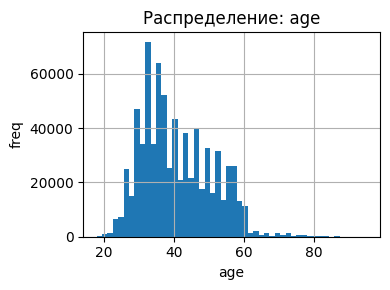

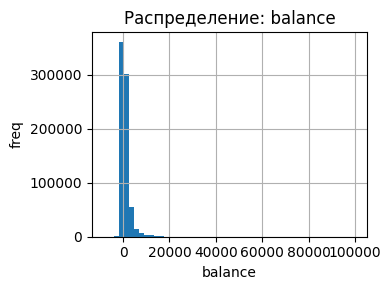

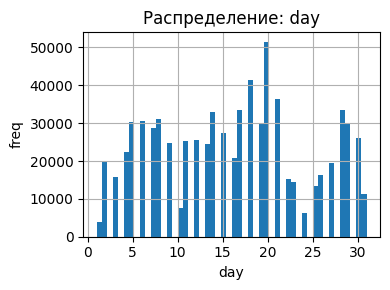

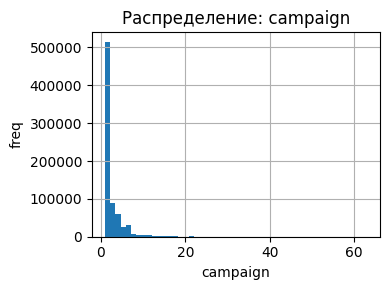

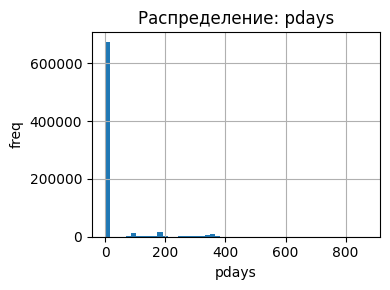

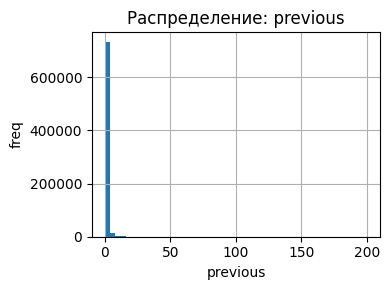

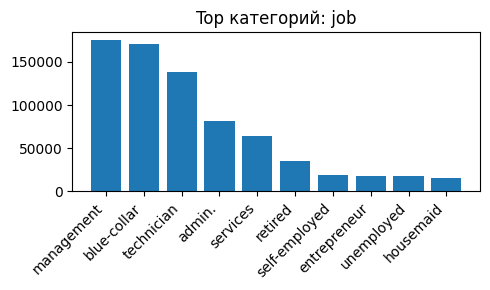

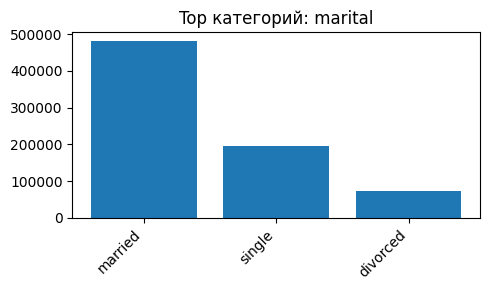

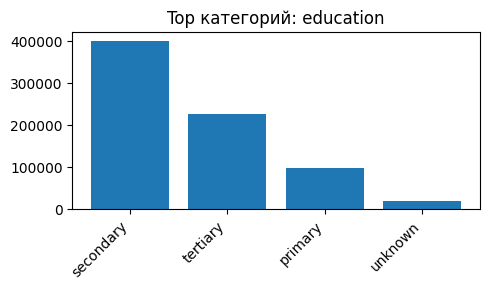

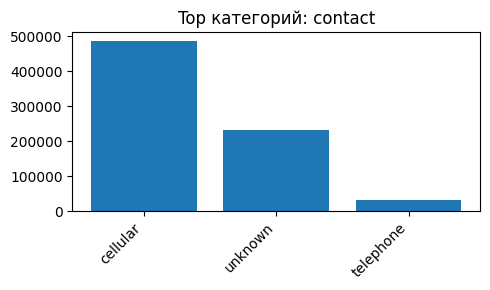

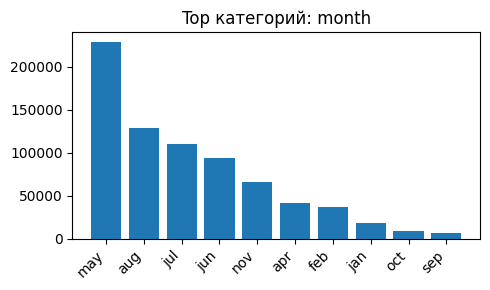

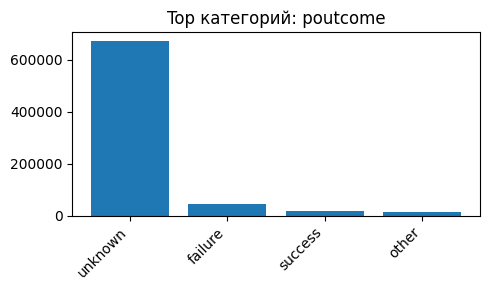

In [ ]:
obj_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = train.select_dtypes(include='number').columns.tolist()
print('object cols:', obj_cols)
print('numeric cols (первые 10):', num_cols[:10])

numeric_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

for col in [c for c in numeric_features if c in train.columns]:
    plt.figure(figsize=(4, 3))
    train[col].hist(bins=50)
    plt.title(f'Распределение: {col}')
    plt.xlabel(col)
    plt.ylabel('freq')
    plt.tight_layout()
    plt.show()

for col in [c for c in categorical_features if c in train.columns]:
    top = train[col].value_counts().head(10)
    plt.figure(figsize=(5, 3))
    plt.bar(top.index.astype(str), top.values)
    plt.title(f'Top категорий: {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

> Распределения числовых признаков (например, `balance`, `pdays`) имеют выраженные хвосты и асимметрию, что типично для банковских данных.  
> Среди категориальных признаков преобладают значения вроде `job=blue-collar`, `education=secondary`, `month=may/jul`, что отражает структуру клиентов и сезонность звонков.  

### 2.2. Корреляции числовых с `y` и замечание про утечки

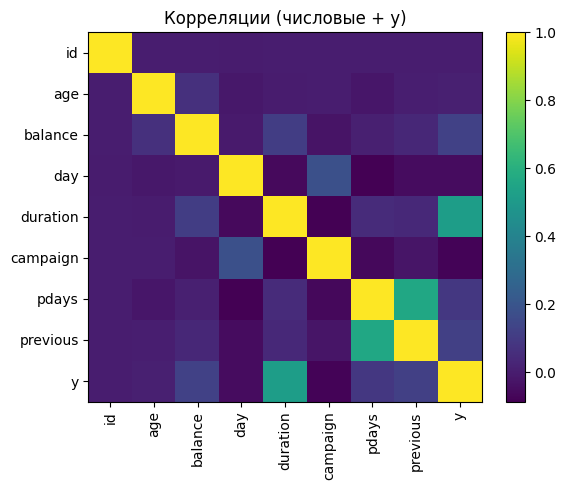

In [ ]:
df_num = train.copy()
df_num['y'] = df_num['y'].astype(int)
num_for_corr = [c for c in num_cols if c != 'y']
corr = df_num[num_for_corr + ['y']].corr(numeric_only=True)
plt.figure(figsize=(6, 5))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Корреляции (числовые + y)')
plt.tight_layout()
plt.show()

> Существенных линейных корреляций с целевой переменной не наблюдается — большинство признаков слабо связаны с `y`.  
> Это ожидаемо для маркетинговых данных, где взаимодействия часто нелинейные.  
> Признак `duration` показывает заметную корреляцию, но он является **постфактум-фичей** и будет исключён из обучения, чтобы избежать утечки.

## 3. Препроцессинг
- `yes/no → {0,1}` для `default, housing, loan`;
- `pdays_is_never = (pdays == -1)`;
- `use_duration = False` по умолчанию.

In [ ]:
USE_DURATION = False


def map_yes_no(df, cols):
    df = df.copy()
    mapping = {'yes': 1, 'no': 0}
    for c in cols:
        if c in df.columns:
            df[c] = df[c].map(mapping)
    return df


def preprocess(df_raw, use_duration: bool = False):
    df = df_raw.copy()
    df = df.drop(columns=['id'], errors='ignore')
    df = map_yes_no(df, ['default', 'housing', 'loan'])
    if 'pdays' in df.columns:
        df['pdays_is_never'] = (df['pdays'] == -1).astype(int)
    numeric = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
    if not use_duration and 'duration' in df.columns:
        df = df.drop(columns=['duration'])
        numeric.remove('duration')
    categorical = [c for c in ['job', 'marital', 'education', 'default', 'housing',
                                'loan', 'contact', 'month', 'poutcome']
                                if c in df.columns]
    return df, numeric, categorical


train_proc, numeric, categorical = preprocess(train, use_duration=USE_DURATION)
test_proc = None if test is None else preprocess(test, use_duration=USE_DURATION)[0]
train_proc.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,pdays_is_never
0,42,technician,married,secondary,0,7,0,0,cellular,25,aug,3,-1,0,unknown,0,1
1,38,blue-collar,married,secondary,0,514,0,0,unknown,18,jun,1,-1,0,unknown,0,1
2,36,blue-collar,married,secondary,0,602,1,0,unknown,14,may,2,-1,0,unknown,0,1
3,27,student,single,secondary,0,34,1,0,unknown,28,may,2,-1,0,unknown,0,1
4,26,technician,married,secondary,0,889,1,0,cellular,3,feb,1,-1,0,unknown,1,1


## 4. Обучение моделей (LogReg, RF, HGBT, CatBoost)
- Линейные: StandardScaler + OneHotEncoder;
- Деревья/бустинг: OrdinalEncoder, числа — как есть;
- CatBoost: нативные категориальные (передаём индексы категорий).

In [ ]:
X = train_proc.drop(columns=['y'])
y = train_proc['y'].astype(int)
Xtr, Xva, ytr, yva = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

c_column = [c for c in numeric if c in X.columns]


def make_linear_preprocessor(numeric, categorical):
    return ColumnTransformer([
        ('num', StandardScaler(), c_column),
        ('cat', OneHotEncoder(handle_unknown='ignore'), c_column)
    ])


def make_tree_preprocessor(numeric, categorical):
    return ColumnTransformer([
        ('num', 'passthrough', c_column),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1), c_column)
    ])


def best_thr_f1(y_true, y_prob):
    qs = np.linspace(0, 1, 2001)
    thrs = np.quantile(y_prob, qs)
    best_t, best_s = 0.5, -1
    for t in np.unique(thrs):
        yhat = (y_prob >= t).astype(int)
        s = f1_score(y_true, yhat, zero_division=0)
        if s > best_s:
            best_s, best_t = s, float(t)
    return best_t


def eval_metrics(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'threshold': thr,
    }


results = {}

# 1) Logistic Regression
pre_l = make_linear_preprocessor(numeric, categorical)
lr = Pipeline([
    ('pre', pre_l),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
])

t0 = time.perf_counter()
lr.fit(Xtr, ytr)
print(f'LogReg fit: {time.perf_counter() - t0:.2f}s')

p_lr = lr.predict_proba(Xva)[:, 1]
thr_lr = best_thr_f1(yva, p_lr)
results['logreg'] = eval_metrics(yva, p_lr, thr_lr)
print('LogReg metrics:', results['logreg'])

# 2) Random Forest
pre_t = make_tree_preprocessor(numeric, categorical)
rf = Pipeline([
    ('pre', pre_t),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=SEED,
        class_weight='balanced'
    ))
])
t0 = time.perf_counter()
rf.fit(Xtr, ytr)
print(f'RF fit: {time.perf_counter() - t0:.2f}s')
p_rf = rf.predict_proba(Xva)[:, 1]
thr_rf = best_thr_f1(yva, p_rf)
results['rf'] = eval_metrics(yva, p_rf, thr_rf)
print('RF metrics:', results['rf'])

# 3) HistGradientBoosting
hgbt = Pipeline([
    ('pre', pre_t),
    ('clf', HistGradientBoostingClassifier(
        max_leaf_nodes=31,
        learning_rate=0.1,
        random_state=SEED
    ))
])
t0 = time.perf_counter()
hgbt.fit(Xtr, ytr)
print(f'HGBT fit: {time.perf_counter() - t0:.2f}s')

p_hgbt = hgbt.predict_proba(Xva)[:, 1]
thr_hgbt = best_thr_f1(yva, p_hgbt)
results['hgbt'] = eval_metrics(yva, p_hgbt, thr_hgbt)
print('HGBT metrics:', results['hgbt'])

# 4) CatBoost — нативные категориальные
cat_idx = [Xtr.columns.get_loc(c) for c in categorical if c in Xtr.columns]
cb = CatBoostClassifier(
    iterations=500, depth=6, learning_rate=0.1,
    loss_function='Logloss', eval_metric='AUC',
    random_seed=SEED, verbose=False, allow_writing_files=False,
)

t0 = time.perf_counter()
cb.fit(Xtr, ytr, cat_features=cat_idx, eval_set=(Xva, yva), verbose=False)
print(f'CatBoost fit: {time.perf_counter() - t0:.2f}s')

p_cb = cb.predict_proba(Xva)[:, 1]
thr_cb = best_thr_f1(yva, p_cb)
results['catboost'] = eval_metrics(yva, p_cb, thr_cb)
print('CatBoost metrics:', results['catboost'])

print('\nСводная таблица метрик (валидация):')
print(pd.DataFrame(results).T)

LogReg fit: 21.92s
LogReg metrics: {'accuracy': 0.8685133333333334, 'precision': 0.45614035087719296, 'recall': 0.4669024201569234, 'f1': 0.4614586462059362, 'roc_auc': 0.783913442225654, 'threshold': 0.6429324818135155}
RF fit: 134.60s
RF metrics: {'accuracy': 0.8716066666666666, 'precision': 0.46977349648529027, 'recall': 0.498508122444469, 'f1': 0.483714446559258, 'roc_auc': 0.8217830855525926, 'threshold': 0.2833333333333333}
HGBT fit: 7.79s
HGBT metrics: {'accuracy': 0.8842333333333333, 'precision': 0.5204463040446304, 'recall': 0.5154713227980993, 'f1': 0.5179468672792382, 'roc_auc': 0.8444808848689656, 'threshold': 0.24926339174005488}
CatBoost fit: 331.79s
CatBoost metrics: {'accuracy': 0.88804, 'precision': 0.5381286549707602, 'recall': 0.5084539728146756, 'f1': 0.52287061764873, 'roc_auc': 0.8470059707240797, 'threshold': 0.26142998817304425}

Сводная таблица метрик (валидация):
          accuracy  precision    recall        f1   roc_auc  threshold
logreg    0.868513   0.4561

> Качество моделей возрастает с увеличением сложности:
> - LogisticRegression служит базовой линией (ROC-AUC ≈ 0.78, F1 ≈ 0.46);  
> - RandomForest и HGBT показывают улучшение (ROC-AUC ≈ 0.82–0.84, F1 ≈ 0.48–0.51);  
> - CatBoost демонстрирует наилучшие результаты (ROC-AUC ≈ 0.84, F1 ≈ 0.52), что согласуется с его преимуществами на категориальных данных.  
> Учитывая дисбаланс классов, метрики F1 и ROC-AUC важнее Accuracy.

## 5. ROC/PR кривые (валидация)

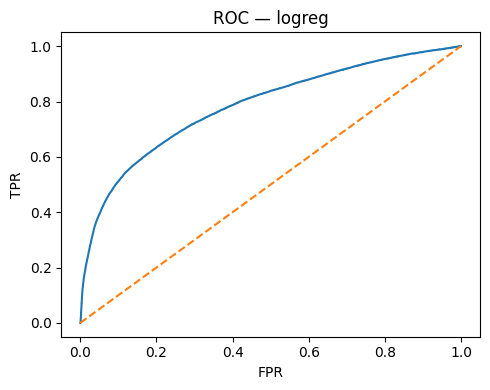

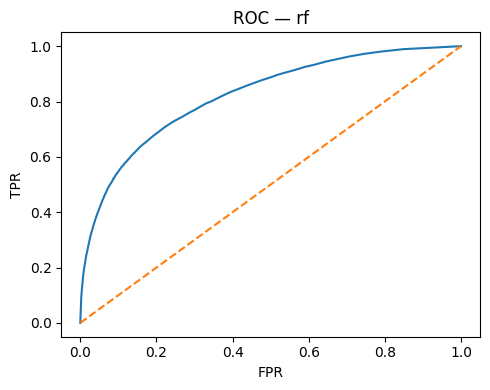

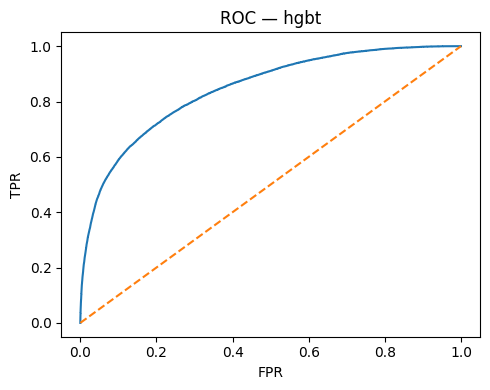

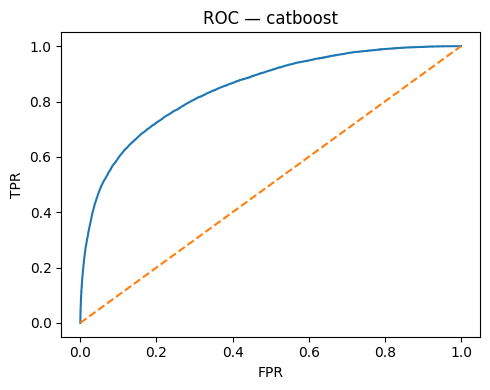

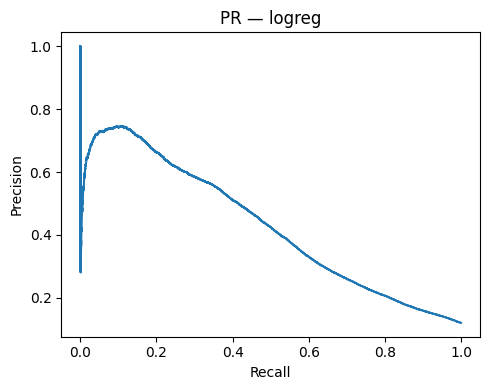

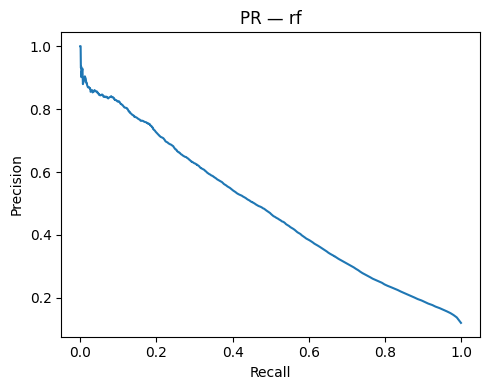

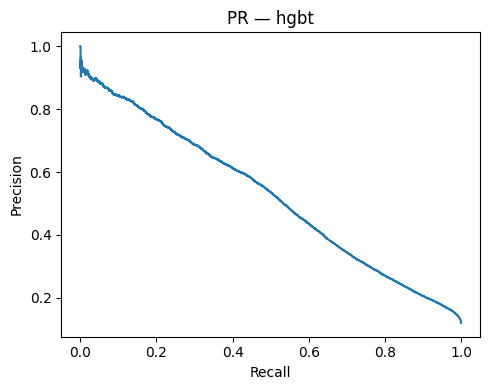

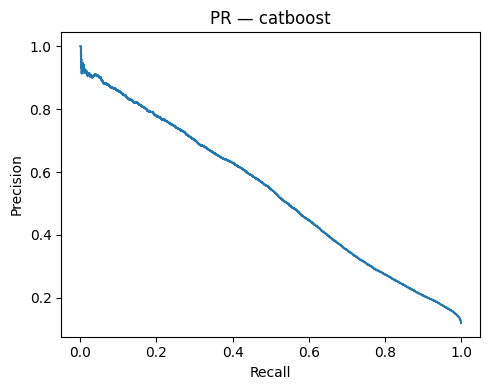

In [ ]:
probas = {
    'logreg': p_lr,
    'rf': p_rf,
    'hgbt': p_hgbt,
    'catboost': p_cb,
}

for name, p in probas.items():
    fpr, tpr, _ = roc_curve(yva, p)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC — {name}')
    plt.tight_layout()
    plt.show()

for name, p in probas.items():
    prec, rec, _ = precision_recall_curve(yva, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR — {name}')
    plt.tight_layout()
    plt.show()

In [ ]:
probas = {
    'logreg': p_lr,
    'rf': p_rf,
    'hgbt': p_hgbt,
    'catboost': p_cb,
}


def summarize(y_true, y_prob, name, thr):
    ap = average_precision_score(y_true, y_prob)  # PR-AUC
    # полезные «бизнес»-точки:
    # recall при precision >= 0.6 и precision при recall >= 0.6
    prec, rec, _ = precision_recall_curve(y_true, y_prob)

    # recall@precision>=0.6
    mask = prec >= 0.6
    rec_at_p06 = rec[mask].max() if mask.any() else 0.0

    # precision@recall>=0.6
    mask = rec >= 0.6
    p_at_r06 = prec[mask].max() if mask.any() else 0.0

    print(f"""{name:9s} | PR-AUC={ap:.4f}
        | recall@P>=0.6={rec_at_p06:.3f}
        | precision@R>=0.6={p_at_r06:.3f} | thr(F1)={thr:.3f}
""")


for name, p in probas.items():
    thr = results[name]['threshold']
    summarize(yva, p, name, thr)


logreg    | PR-AUC=0.4269 | recall@P>=0.6=0.279 | precision@R>=0.6=0.331 | thr(F1)=0.643
rf        | PR-AUC=0.4806 | recall@P>=0.6=0.331 | precision@R>=0.6=0.383 | thr(F1)=0.283
hgbt      | PR-AUC=0.5239 | recall@P>=0.6=0.420 | precision@R>=0.6=0.437 | thr(F1)=0.249
catboost  | PR-AUC=0.5330 | recall@P>=0.6=0.437 | precision@R>=0.6=0.447 | thr(F1)=0.261


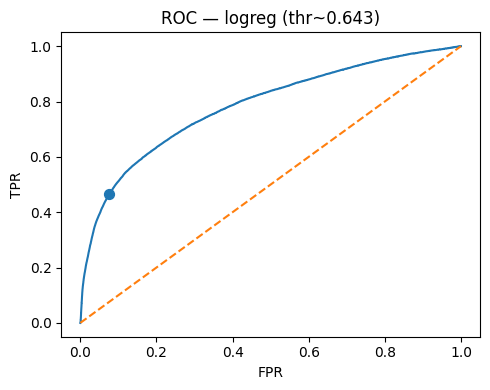

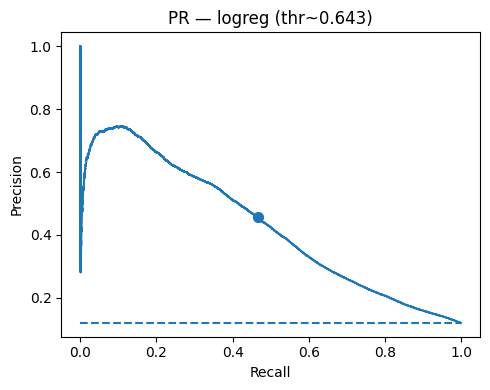

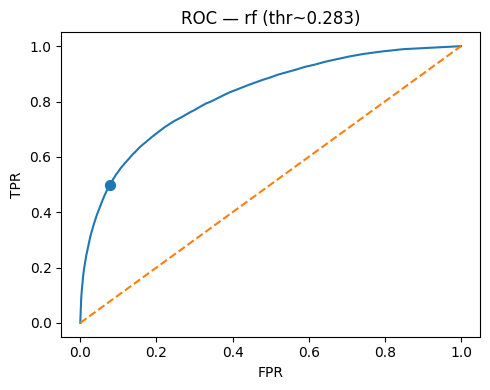

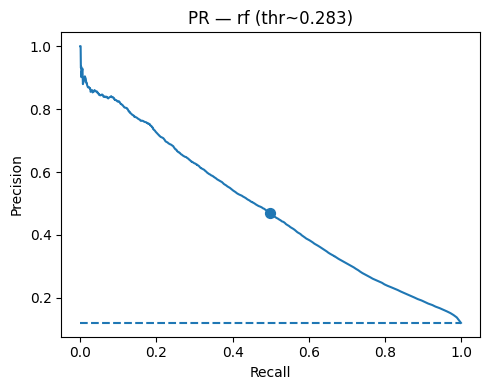

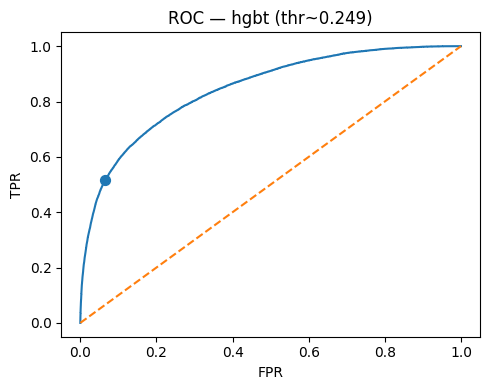

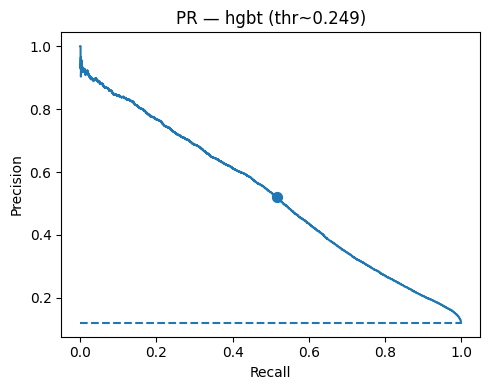

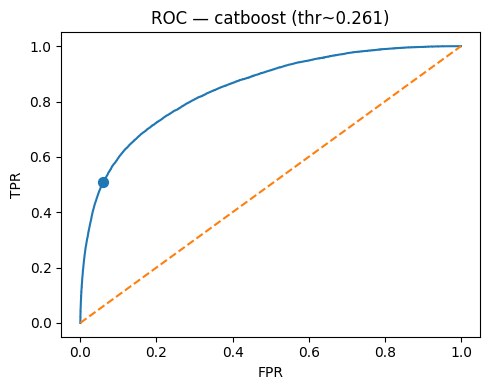

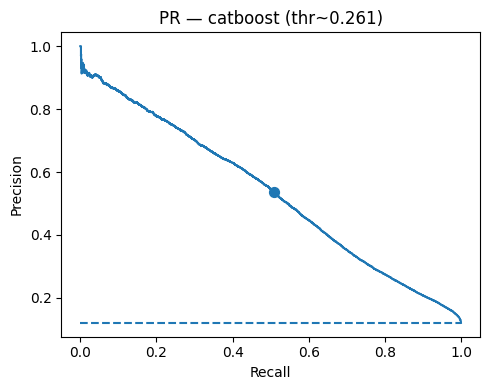

In [ ]:
def plot_with_threshold(y_true, y_prob, thr, name):

    # ROC
    fpr, tpr, ts = roc_curve(y_true, y_prob)
    # ближайшая к thr точка (по вероятности)
    t_idx = np.argmin(np.abs(ts - thr))
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    # точка порога
    if 0 <= t_idx < len(fpr):
        plt.scatter([fpr[t_idx]], [tpr[t_idx]], s=50)
    plt.title(f"ROC — {name} (thr~{thr:.3f})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.tight_layout()
    plt.show()

    # PR
    prec, rec, ts = precision_recall_curve(y_true, y_prob)
    # для PR scikit возвращает ts на длину-1, так что ищем ближайший отдельно
    if len(ts) > 0:
        t_idx = np.argmin(np.abs(ts - thr))
        # точки prec/rec соответствуют ts на тех же индексах
        p_t = prec[t_idx]
        r_t = rec[t_idx]
    else:
        p_t = r_t = None

    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec)
    if p_t is not None:
        plt.scatter([r_t], [p_t], s=50)
    # базовая линия по дисбалансу
    base = y_true.mean()
    plt.hlines(base, 0, 1, linestyles='--')
    plt.title(f"PR — {name} (thr~{thr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()


for name, p in probas.items():
    plot_with_threshold(yva, p, results[name]['threshold'], name)


> ROC-кривые указывают на хорошее разделение классов для всех моделей, особенно для бустингов.  
> PR-кривые подтверждают, что при высоком Recall Precision остаётся на приемлемом уровне — особенно у CatBoost и HGBT.

> На PR-кривых CatBoost/HGBT дольше удерживают высокую precision при росте recall; на ROC в области малого FPR их TPR выше — это критично для задач с ограничением на ложные срабатывания.
> В «рабочем пороге» (под F1) CatBoost даёт выше recall при приемлемой precision, чем деревья/логрег, что и отражается в лучшем F1.

## 6. Важности признаков
- Sklearn-пайплайны: permutation importance (по F1, на валидации);
- CatBoost: `model.get_feature_importance()` (loss-importance).

Permutation Importance — LogisticRegression (top 20)
           feature  importance_mean
8          contact         0.064611
10           month         0.062147
14        poutcome         0.033469
5          balance         0.021015
6          housing         0.017499
12           pdays         0.012333
1              job         0.007352
7             loan         0.006469
11        campaign         0.004245
9              day         0.002011
3        education         0.001208
2          marital         0.001020
13        previous         0.000112
4          default         0.000037
0              age         0.000009
15  pdays_is_never         0.000000


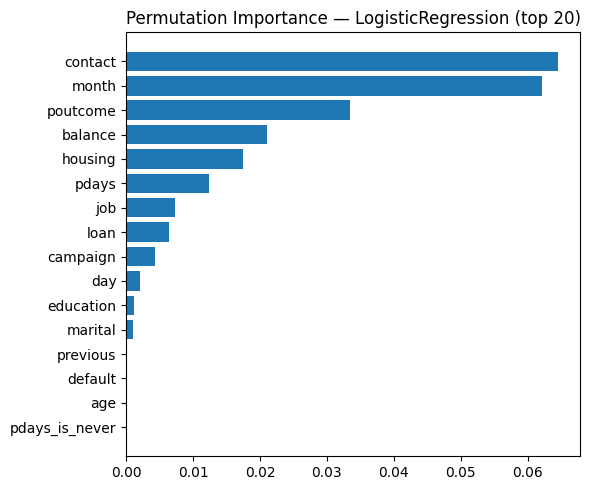

Permutation Importance — RandomForest (top 20)
           feature  importance_mean
12           pdays         0.105969
14        poutcome         0.079564
8          contact         0.073615
5          balance         0.060320
6          housing         0.048986
10           month         0.047119
0              age         0.042368
1              job         0.034169
2          marital         0.032851
11        campaign         0.026221
9              day         0.025362
3        education         0.023248
13        previous         0.019410
7             loan         0.019180
4          default         0.001224
15  pdays_is_never         0.000000


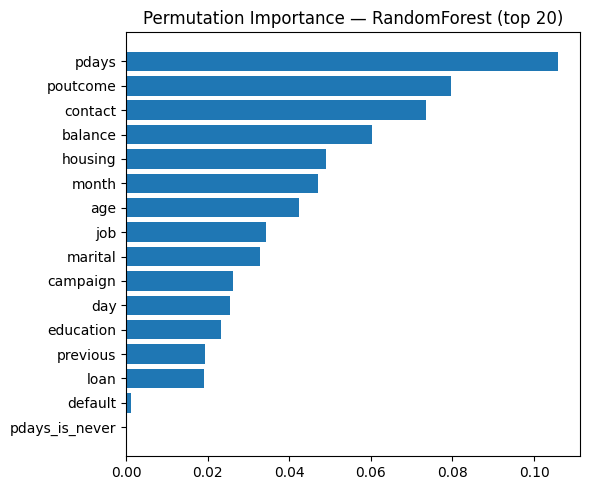

Permutation Importance — HGBT (top 20)
           feature  importance_mean
8          contact         0.099815
10           month         0.066293
12           pdays         0.064227
6          housing         0.063570
5          balance         0.061676
9              day         0.032383
0              age         0.024649
11        campaign         0.023736
7             loan         0.021980
1              job         0.013759
3        education         0.008605
2          marital         0.006332
13        previous         0.000879
4          default         0.000398
14        poutcome         0.000132
15  pdays_is_never         0.000000


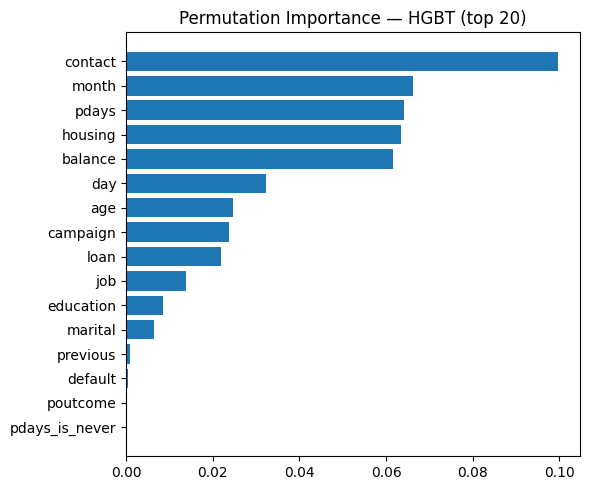

CatBoost Feature Importance (top 20):
           feature  importance
5          balance   30.833539
8          contact   12.448756
10           month   10.499180
9              day    9.197626
14        poutcome    7.587412
6          housing    6.636911
11        campaign    5.942664
0              age    4.948259
12           pdays    3.577732
7             loan    2.566398
2          marital    2.363288
1              job    1.423715
3        education    1.044918
4          default    0.443538
13        previous    0.440255
15  pdays_is_never    0.045811


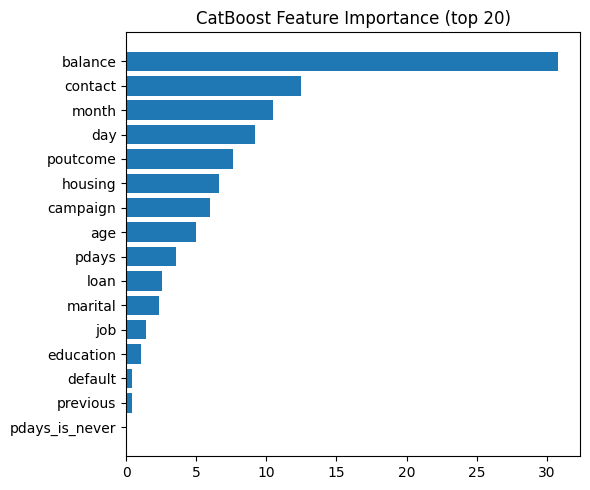

In [ ]:
from sklearn.inspection import permutation_importance


def show_perm_importance(pipe, Xva, yva, title):
    r = permutation_importance(
        pipe, Xva, yva,
        n_repeats=5, random_state=SEED, scoring='f1'
    )
    feats = Xva.columns
    imp = (
        pd.DataFrame({
            'feature': feats,
            'importance_mean': r.importances_mean
        })
        .sort_values('importance_mean', ascending=False)
        .head(20)
    )
    print(title)
    print(imp)
    plt.figure(figsize=(6, 5))
    plt.barh(imp['feature'][::-1], imp['importance_mean'][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()


show_perm_importance(
    lr,
    Xva,
    yva,
    'Permutation Importance — LogisticRegression (top 20)'
)
show_perm_importance(rf, Xva, yva, 'Permutation Importance — RandomForest (top 20)')
show_perm_importance(hgbt, Xva, yva, 'Permutation Importance — HGBT (top 20)')


cb_imp = cb.get_feature_importance(type='FeatureImportance')
cb_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': cb_imp
}).sort_values('importance', ascending=False).head(20)
print('CatBoost Feature Importance (top 20):')
print(cb_imp_df)
plt.figure(figsize=(6, 5))
plt.barh(cb_imp_df['feature'][::-1], cb_imp_df['importance'][::-1])
plt.title('CatBoost Feature Importance (top 20)')
plt.tight_layout()
plt.show()

> Важнейшие признаки по permutation importance и CatBoost:
> - `contact`, `month`, `poutcome`, `pdays`, `balance`, `job`, `education`, `housing`;  
> Это логично: канал связи, время контакта и результаты прошлых кампаний напрямую влияют на вероятность подписки.  
> Высокие важности социально-демографических факторов также подтверждают маркетинговую природу задачи.

## 7. Инференс на тесте (если `test.csv` есть)

In [39]:
if test is not None:
    test_proc = preprocess(test, use_duration=USE_DURATION)[0]
    print('test_proc shape:', test_proc.shape)

    preds = {
        'p_logreg':  lr.predict_proba(test_proc)[:, 1],
        'p_rf':      rf.predict_proba(test_proc)[:, 1],
        'p_hgbt':    hgbt.predict_proba(test_proc)[:, 1],
        'p_catboost': cb.predict_proba(test_proc)[:, 1],
    }

    sub = pd.DataFrame({'id': np.arange(len(test_proc))})
    for col_name, arr in preds.items():
        sub[col_name] = arr

    out_dir = Path('artifacts')
    out_dir.mkdir(exist_ok=True)
    out_path = out_dir / 'nb_preds_test.csv'
    sub.to_csv(out_path, index=False)
    print(f'Saved: {out_path}')
    display(sub.head())
else:
    print('test.csv отсутствует — инференс пропущен.')

test_proc shape: (250000, 16)
Saved: artifacts\nb_preds_test.csv


,id,p_logreg,p_rf,p_hgbt,p_catboost
0,0,0.180039,0.010000,0.050480,0.041335
1,1,0.587490,0.153333,0.034470,0.062391
2,2,0.250546,0.070000,0.070420,0.063572
3,3,0.077184,0.003333,0.003474,0.002496
4,4,0.504887,0.213333,0.221002,0.221728


> Получен файл `artifacts/nb_preds_test.csv` с вероятностями по четырём моделям.  
> Его можно использовать для сравнения ансамблей или как входные данные для бизнес-аналитики (например, таргетинга клиентов).

## Заключение
> После анализа и обучения моделей лучшим компромиссом качества и интерпретируемости является **CatBoost**, далее — **HistGradientBoosting**.  
> Модели адекватно отражают влияние сезонности (`month`), канала (`contact`) и истории клиента (`poutcome`).  
> Для промышленного применения рекомендуется кросс-валидация по месяцам и регулярный мониторинг качества из-за сезонных колебаний данных.